In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Sequential, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2
from timm import create_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras import layers, models, mixed_precision


In [25]:
DATA_DIR = '../data/raw/'
BATCH_SIZE = 8
IMG_SIZE = (224,224)

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    label_mode='binary',
    batch_size=32,
    image_size=(224, 224),  # Ensure resizing images to 224x224
    shuffle=True
)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data = dataset.take(train_size)
val_data = dataset.skip(train_size).take(val_size)


Found 2804 files belonging to 2 classes.


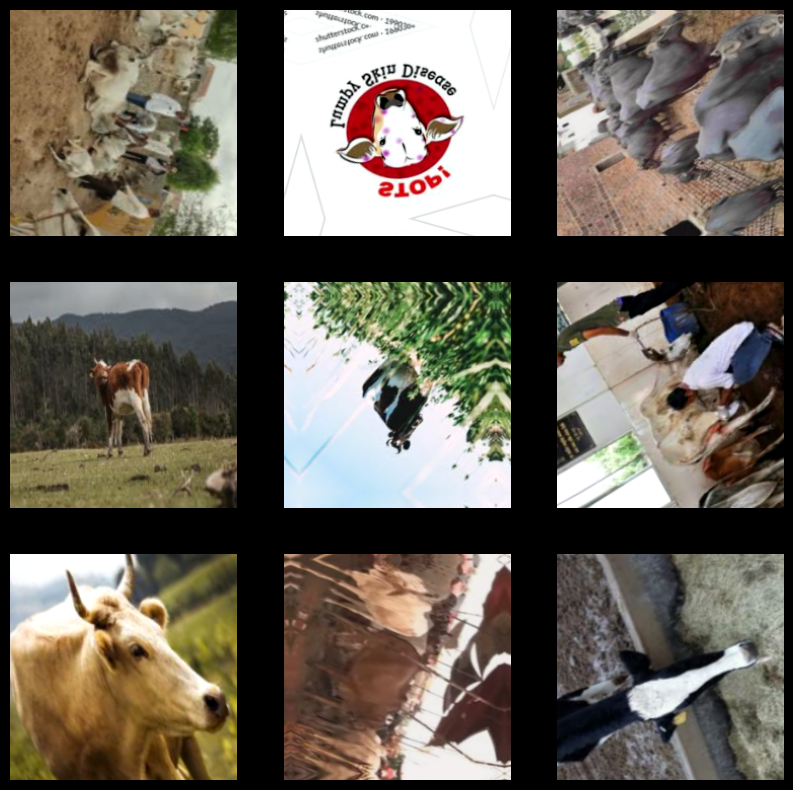

In [3]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

# Visualize augmented data
for images, _ in train_data.take(1):
    augmented_images = data_augmentation(images)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis('off')
    plt.show()


In [20]:
def clean_images(img_dir, target_size=(IMG_SIZE[0], IMG_SIZE[1])):
    classes = os.listdir(img_dir)
    for class_name in classes:
        class_path = os.path.join(img_dir, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, target_size)
                    if img is not None and img.shape[2] == 3:
                        cv2.imwrite(img_path, img)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

clean_images(DATA_DIR)


In [28]:
import cv2
def add_gaussian_noise(img):
    noise = np.random.normal(0, 25, img.shape).astype(np.uint8)
    noisy_img = cv2.add(img, noise)
    return noisy_img

def add_salt_and_pepper_noise(img, salt_prob=0.02, pepper_prob=0.02):
    noisy_img = img.copy()
    total_pixels = img.size // 3
    num_salt = int(total_pixels * salt_prob)
    num_pepper = int(total_pixels * pepper_prob)

    # Add salt noise
    coords = [np.random.randint(0, i - 1, num_salt) for i in img.shape]
    noisy_img[coords[0], coords[1], :] = 255

    # Add pepper noise
    coords = [np.random.randint(0, i - 1, num_pepper) for i in img.shape]
    noisy_img[coords[0], coords[1], :] = 0

    return noisy_img

def apply_noise_to_dataset(img_dir, noise_type='gaussian'):
    classes = os.listdir(img_dir)
    for class_name in classes:
        class_path = os.path.join(img_dir, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    if noise_type == 'gaussian':
                        noisy_img = add_gaussian_noise(img)
                    elif noise_type == 'salt_and_pepper':
                        noisy_img = add_salt_and_pepper_noise(img)
                    cv2.imwrite(img_path.replace('.jpg', '_noisy.jpg'), noisy_img)

apply_noise_to_dataset(DATA_DIR, noise_type='salt_and_pepper')


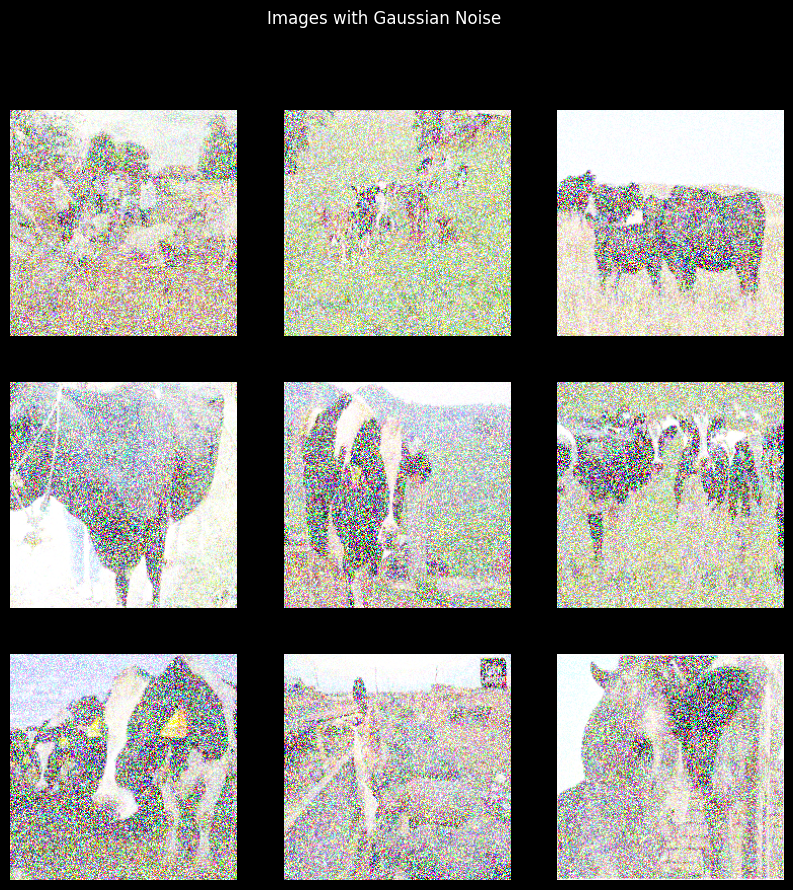

In [10]:
# Visualize data after noise addition
for images, labels in train_data.take(1):
    noisy_images = np.array([add_gaussian_noise(img.numpy().astype("uint8")) for img in images])
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(noisy_images[i])
        plt.axis('off')
    plt.suptitle("Images with Gaussian Noise")
    plt.show()

In [26]:
for images, labels in dataset.take(1):
    print(images.shape)  # Should output (batch_size, 224, 224, 3)


(32, 224, 224, 3)


In [29]:
# Function to build the Swin Transformer model
def build_swin_transformer_model(input_shape=(224, 224, 3)):
    base_model = create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=0, in_chans=3)
    base_model.trainable = True
    
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model

In [12]:
def build_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)):
    model = Sequential([
        data_augmentation,
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


In [13]:
def build_vgg16(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)):
    base_model = VGG16(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False
    model = Sequential([
        data_augmentation,
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


In [14]:
def build_resnet50(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)):
    base_model = ResNet50(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False
    model = Sequential([
        data_augmentation,
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


Training CNN...
Epoch 1/15
70/70 [==============================] - 49s 507ms/step - loss: 5.0728 - accuracy: 0.5241 - val_loss: 0.5854 - val_accuracy: 0.5691
Epoch 2/15
70/70 [==============================] - 34s 478ms/step - loss: 0.6937 - accuracy: 0.5442 - val_loss: 0.6169 - val_accuracy: 0.5887
Epoch 3/15
70/70 [==============================] - 34s 480ms/step - loss: 0.6523 - accuracy: 0.5545 - val_loss: 0.5993 - val_accuracy: 0.6968
Epoch 4/15
1/1 [==============================] - 1s 613ms/step
Evaluation Metrics for CNN:
              precision    recall  f1-score   support

         0.0       0.39      1.00      0.56         7
         1.0       0.00      0.00      0.00        11

    accuracy                           0.39        18
   macro avg       0.19      0.50      0.28        18
weighted avg       0.15      0.39      0.22        18



c:\Users\DHANUSH\anaconda3\envs\py_env\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DHANUSH\anaconda3\envs\py_env\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DHANUSH\anaconda3\envs\py_env\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

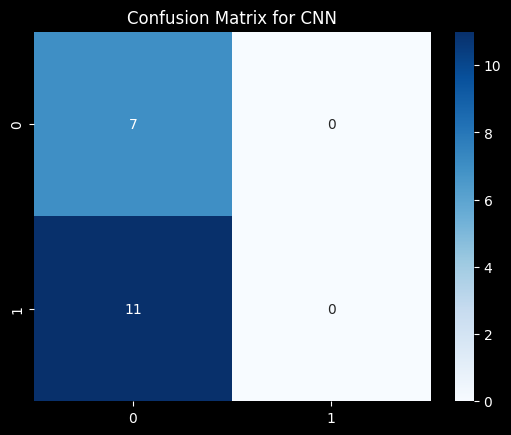

Training ResNet50...
Epoch 1/15
70/70 [==============================] - 59s 685ms/step - loss: 0.7386 - accuracy: 0.6174 - val_loss: 0.5147 - val_accuracy: 0.7287
Epoch 2/15
70/70 [==============================] - 40s 577ms/step - loss: 0.5868 - accuracy: 0.7049 - val_loss: 0.4685 - val_accuracy: 0.7766
Epoch 3/15
70/70 [==============================] - 39s 558ms/step - loss: 0.5286 - accuracy: 0.7429 - val_loss: 0.4311 - val_accuracy: 0.8050
Epoch 4/15
70/70 [==============================] - 37s 521ms/step - loss: 0.5075 - accuracy: 0.7504 - val_loss: 0.4216 - val_accuracy: 0.8191
Epoch 5/15
70/70 [==============================] - 45s 637ms/step - loss: 0.4856 - accuracy: 0.7647 - val_loss: 0.4005 - val_accuracy: 0.8138
Epoch 6/15
70/70 [==============================] - 43s 615ms/step - loss: 0.4750 - accuracy: 0.7728 - val_loss: 0.4019 - val_accuracy: 0.8085
Epoch 7/15
70/70 [==============================] - 37s 533ms/step - loss: 0.4637 - accuracy: 0.7884 - val_loss: 0.4188 -

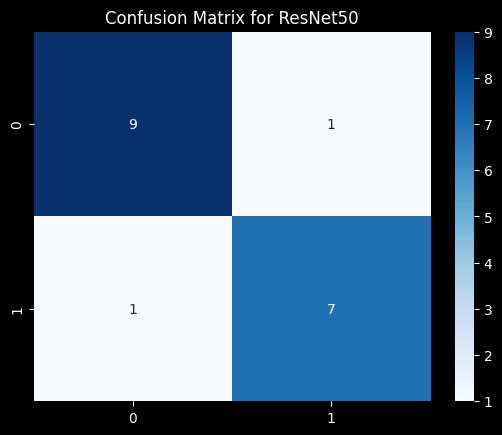

Training VGG16...
Epoch 1/15
70/70 [==============================] - 64s 707ms/step - loss: 2.0092 - accuracy: 0.5304 - val_loss: 1.0825 - val_accuracy: 0.5975
Epoch 2/15
70/70 [==============================] - 44s 627ms/step - loss: 1.4504 - accuracy: 0.5763 - val_loss: 0.8793 - val_accuracy: 0.6259
Epoch 3/15
70/70 [==============================] - 44s 630ms/step - loss: 1.1662 - accuracy: 0.5969 - val_loss: 0.7299 - val_accuracy: 0.6738
Epoch 4/15
70/70 [==============================] - 44s 628ms/step - loss: 0.9876 - accuracy: 0.6183 - val_loss: 0.6854 - val_accuracy: 0.6915
Epoch 5/15
70/70 [==============================] - 44s 629ms/step - loss: 0.8784 - accuracy: 0.6232 - val_loss: 0.6831 - val_accuracy: 0.6862
Epoch 6/15
70/70 [==============================] - 48s 684ms/step - loss: 0.7626 - accuracy: 0.6496 - val_loss: 0.5955 - val_accuracy: 0.7110
Epoch 7/15
70/70 [==============================] - 50s 711ms/step - loss: 0.6970 - accuracy: 0.6634 - val_loss: 0.5657 - va

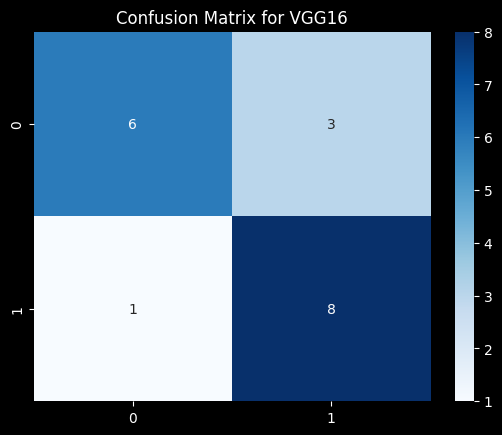

In [31]:
EPOCHS = 15
models_dict = {
    'CNN': build_cnn(),
    'ResNet50': build_resnet50(),
    'VGG16': build_vgg16(),
    # 'Swin Transformer': build_swin_transformer_model()
}

for model_name, model in models_dict.items():
    print(f"Training {model_name}...")
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint(f'../models/{model_name}_best.h5', save_best_only=True)
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
    
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=EPOCHS,
        callbacks=[checkpoint, early_stopping]
    )

    # Evaluate model
    val_images, val_labels = next(iter(val_data.unbatch().batch(len(val_data))))
    preds = model.predict(val_images)
    preds_binary = (preds > 0.5).astype(int)
    print(f"Evaluation Metrics for {model_name}:")
    print(classification_report(val_labels, preds_binary))
    cm = confusion_matrix(val_labels, preds_binary)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()
